# RIS Enhanced Communication

## System Model

Consider a system with a single base station ($\mathrm{BS}$) and a single user ($\mathrm{UE}$), aided by reconfigurable intelligent surface (RIS) ($\mathrm{R}$) with $K$ reflecting elements.

_For the sake of simplicity, assume that both base station and users are equipped with a single antenna._

<div align="center">
<img src="../resources/ris_system.png" width="500">
</div>

<div align="center">
Fig. 1. RIS-aided system model.
</div>

Without an RIS, the received signal at $\mathrm{UE}$ for a single transmitted symbol $x$ can be expressed as

$$
y = h_d\,x + n,
$$

where $h_d$ is the direct channel gain between $\mathrm{BS}$ and $\mathrm{UE}$, and $n$ is the additive white Gaussian noise (AWGN) at $\mathrm{UE}$ with zero mean and variance $\sigma^2$.

Now, what an RIS does is to reflect the incident signal from $\mathrm{BS}$ to $\mathrm{UE}$, essentially creating a virtual line-of-sight (vLOS) link between $\mathrm{BS}$ and $\mathrm{UE}$. The channel gain of the reflected signal can be expressed as

$$
h_{\text{cascade}} = \mathbf{H}_{t, R}^T \mathbf{\Theta} \mathbf{H}_{R, r},
$$

where $\mathbf{H}_{t, R}^T \in \mathbb{C}^{1 \times K}$ and $\mathbf{H}_{R, r} \in \mathbb{C}^{K \times 1}$ are the channel gains between $\mathrm{BS}$ and $\mathrm{R}$, and $\mathrm{R}$ and $\mathrm{UE}$, respectively. Furthermore, $\mathbf{\Theta} = \text{diag}(a_1 \exp(j \phi_1), a_2 \exp(j \phi_2), \ldots, a_K \exp(j \phi_K))$ is the diagonal matrix representing the reflection coefficients of the RIS elements, where $a_k \in [0, 1]$ and $\phi_k \in [0, 2\pi]$ are the amplitude and phase of the $k$-th RIS element, respectively. For this example, we assume that the RIS elements are ideal, i.e., $a_k = 1$ and phase shifts are continuous.

The received signal at $\mathrm{UE}$ can now be expressed as

$$
y = h_{\text{eff}}\,x + n,
$$

where $h_{\text{eff}} = h_d + h_{\text{cascade}}$ is the effective channel gain between $\mathrm{BS}$ and $\mathrm{UE}$.

## Simulation

In [1]:
from comyx.network import (
    UserEquipment,
    BaseStation,
    RIS,
    cascaded_channel_gain,
    effective_channel_gain,
)
from comyx.core import SISOCollection
from comyx.propagation import get_noise_power
from comyx.utils import dbm2pow, get_distance

import numpy as np
from numba import jit
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams["figure.figsize"] = (6, 4)

### Setup Environment

In [2]:
Pt = np.linspace(-40, -10, 60)  # dBm
Pt_lin = dbm2pow(Pt)  # Watt
bandwidth = 1e6  # Bandwidth in Hz
frequency = 2.4e9  # Carrier frequency
temperature = 300  # Kelvin
mc = 100000  # Number of channel realizations

N0 = get_noise_power(temperature, bandwidth)  # dBm
N0_lin = dbm2pow(N0)  # Watt

nlos_fading_args = {
    "type": "nakagami",
    "m": 1,
    "omega": 1
}
los_fading_args = {
    "type": "nakagami",
    "m": 2,
    "omega": 1
}

pathloss_args = {
    "type": "reference",
    "alpha": 3,
    "p0": 25,
    "frequency": frequency,
}  # p0 is the reference power in dBm

In [3]:
BS = BaseStation("BS", position=[0, 0, 10], n_antennas=1, t_power=Pt_lin)
UE = UserEquipment("UE", position=[30, 30, 1], n_antennas=1)
R = RIS("RIS", position=[15, 15, 5], n_elements=100)

R.amplitudes = np.ones(R.n_elements)  # ideal elements

print("Distance between BS and UEn:", get_distance(BS.position, UE.position))
print("Distance between BS and RIS:", get_distance(BS.position, R.position))
print("Distance between UE and RIS:", get_distance(UE.position, R.position))

Distance between BS and UEn: 43.37049688440288
Distance between BS and RIS: 21.79449471770337
Distance between UE and RIS: 21.587033144922902


### Initialize Links

In [4]:
# As per the docs,SISOCollection's links can be to and from
# any of the following: UserEquipment, BaseStation, RIS
link_col = SISOCollection(realizations=mc)

# Add links to the collection
link_col.add_link([BS, UE], nlos_fading_args, pathloss_args)
link_col.add_link([BS, R, UE], los_fading_args, pathloss_args)

### Optimize Phase Shifts

Assuming full channel state information (CSI) is available to $\mathrm{R}$, the phase shifts can be optimized if the reflected link is coherent with the direct link. In other words, for each element $k$, we have

$$
\angle h_{\text{cascade}} = \angle h_{t, k} + \phi_k + \angle h_{k, r} = \angle h_d,
$$

where $h_{t, k}$ and $h_{k, r}$ are complex scalars of the vectors $\mathbf{H}_{t, R}$ and $\mathbf{H}_{R, r}$, indexed by $k$. As per the above discussion, the optimal phase shift for the $k$-th element can be expressed as

$$
\phi_k = \angle h_d - \angle h_{t, k} - \angle h_{k, r}.
$$

In [5]:
theta_d = link_col.get_angle("BS->UE")
theta_tR = link_col.get_angle("BS->RIS")
theta_Rr = link_col.get_angle("RIS->UE")

# Shapes for ease-of-use
print("theta_d shape:", theta_d.shape)
print("theta_tR shape:", theta_tR.shape)
print("theta_Rr shape:", theta_Rr.shape)

theta_d shape: (1, 1, 100000)
theta_tR shape: (1, 100, 100000)
theta_Rr shape: (100, 1, 100000)


In [6]:
R.phase_shifts = np.squeeze(theta_d) - np.squeeze(theta_tR) - np.squeeze(theta_Rr)

### Effective Channel Gain

`comyx` has in-built functions to calculate the cascaded and effective channel gains.

In [7]:
gain_cascade = cascaded_channel_gain(link_col.get_link("BS->RIS->UE"))
gain_eff = effective_channel_gain(
    link_col.get_link("BS->UE"), link_col.get_link("BS->RIS->UE")
)

In [8]:
# Magnitude of the channel gains
mag_d = link_col.get_magnitude("BS->UE") ** 2
mag_eff = np.abs(gain_eff) ** 2

UE.sinr_wRIS = np.zeros((len(Pt), mc))
UE.sinr_woRIS = np.zeros((len(Pt), mc))

for i, p in enumerate(Pt_lin):
    p = BS.t_power[i]
    UE.sinr_wRIS[i, :] = (p * mag_eff) / N0_lin  # SINR with RIS
    UE.sinr_woRIS[i, :] = (p * mag_d) / N0_lin  # SINR without RIS

rate_wRIS = np.log2(1 + UE.sinr_wRIS)
rate_woRIS = np.log2(1 + UE.sinr_woRIS)

# Rate thresholds
thresh = 3

# JIT compiled as mc can be very large (>> 10000)
@jit(nopython=True)
def get_outage(rate, thresh):
    outage = np.zeros((len(Pt), 1))

    for i in range(len(Pt)):
        for k in range(mc):
            if rate[i, k] < thresh:
                outage[i] += 1

    return outage


UE.outage_wRIS = get_outage(rate_wRIS, thresh) / mc
UE.outage_woRIS = get_outage(rate_woRIS, thresh) / mc

### Results

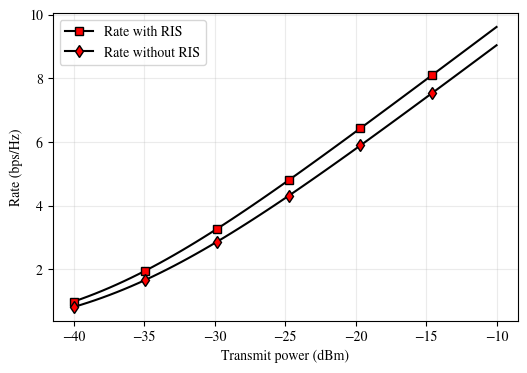

In [9]:
plot_args = {
    "markevery": 10,
    "color": "k",
    "markerfacecolor": "r",
}

UE.rate_wRIS = np.mean(rate_wRIS, axis=-1)
UE.rate_woRIS = np.mean(rate_woRIS, axis=-1)

# Plot achievable rates
plt.figure()
plt.plot(Pt, UE.rate_wRIS, label="Rate with RIS", marker="s", **plot_args)
plt.plot(Pt, UE.rate_woRIS, label="Rate without RIS", marker="d", **plot_args)
plt.xlabel("Transmit power (dBm)")
plt.ylabel("Rate (bps/Hz)")
plt.grid(alpha=0.25)
plt.legend()
plt.show()

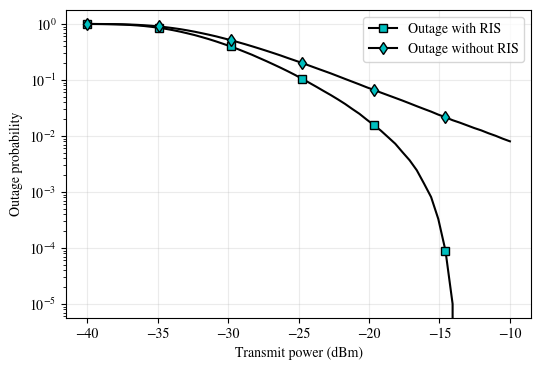

In [10]:
plot_args = {
    "markevery": 10,
    "color": "k",
    "markerfacecolor": "c",
}

# Plot outage probabilities
plt.figure()
plt.semilogy(Pt, UE.outage_wRIS, label="Outage with RIS", marker="s", **plot_args)
plt.semilogy(Pt, UE.outage_woRIS, label="Outage without RIS", marker="d", **plot_args)
plt.xlabel("Transmit power (dBm)")
plt.ylabel("Outage probability")
plt.grid(alpha=0.25)
plt.legend()
plt.show()